In [1]:
import numpy as np
from dolfin import *

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

```python 
def set_sources():
    num_src = 1000 #np.random.randint(1,10)
    side = np.random.randint(2,size = num_src)
    pos = np.random.rand(num_src)
    coords = np.vstack((side,pos))
    return np.apply_along_axis(np.random.permutation,0,coords)
```

In [194]:
def set_srcs():
    """
    This method (equivalent of the one above) randomly places points 
    along the border. The number of points `num_srcs` is randomly 
    chosen as well.
    """    
    num_src = np.random.randint(1,2)
    xy,s = np.split(np.random.randint(2,size = 2 * num_src),2)
    yx = np.random.rand(num_src)
    coords = np.vstack((xy,yx))
    rows,cols = np.ogrid[:coords.shape[0],:coords.shape[1]]
    rows = rows - s
    return coords[rows,cols]

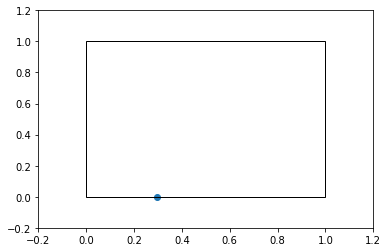

In [195]:
x,y = set_srcs()
fig,ax = plt.subplots()
ax.scatter(x,y)
rect = Rectangle((0,0),1,1,fill=False)
ax.add_patch(rect)
ax.set_ylim(-0.2,1.2)
ax.set_xlim(-0.2,1.2)
srcs = np.hstack((x[:,np.newaxis],y[:,np.newaxis]))

In [196]:
mesh = UnitSquareMesh(8,8)
V = FunctionSpace(mesh,'P',1)

In [197]:
class Points(SubDomain):
    def __init__(self,srcs):
        super().__init__()
        self.srcs = srcs
        
    def check(self,x,srcs):
        A = np.tile(x,(srcs.shape[0],1))
        bool_A = np.isclose(A,srcs)
        return np.multiply.reduce(bool_A,1).sum()
    
    def inside(self,x,on_boundary):
        return self.check(x,self.srcs)
    
class Punctures(Points):
    def init(self,srcs):
        super().__init__(srcs)
        
    def inside(self,x,on_boundary):
        return on_boundary and not self.check(x,self.srcs)

In [199]:
points = Points(srcs)
punctures = Punctures(srcs)
bc1 = DirichletBC(V,Constant(1.),points,method="pointwise")
bc2 = DirichletBC(V,Constant(0.),punctures,method="pointwise")
bcs = [bc1,bc2]

In [200]:
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx
L = Constant(0.) * v * dx

In [201]:
u = Function(V)
solve(a == L,u,bcs)

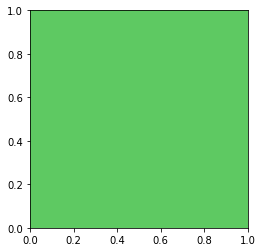

In [202]:
plot(u)